# Оценка риска ДТП

## Описание проекта

Нам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение.

Ввиду данных из таблиц ограничемся следующей задачей — понять, возможно ли предсказывать виновника ДТП, опираясь на исторические данные одного из регионов.

### Цель проекта

Идея решения задачи от заказчика:

1. Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)

  * Для модели выбрать тип виновника — только машина (car).
  * Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
  * Для моделирования ограничиться данными за 2012 год — данных за этот год больше всего.

2. На основе модели исследовать основные факторы ДТП.

3. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
  * Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
  * Какие ещё факторы нужно учесть?
  * Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Заказчик предлагает нам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы.

### Описание данных

Краткое описание таблиц:

* **collisions** — общая информация о ДТП

  Имеет уникальный *case_id*. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

* **parties** — информация об участниках ДТП

  Имеет неуникальный *case_id*, который сопоставляется с соответствующим ДТП в таблице **collisions**. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением *case_id*. Если нужен уникальный идентификатор, это *case_id and party_number*.

* **vehicles** — информация о пострадавших машинах

  Имеет неуникальные *case_id* и неуникальные *party_number*, которые сопоставляются с таблицей **collisions** и таблицей **parties**. Если нужен уникальный идентификатор, это *case_id and party_number*.

* **case_ids** — информация о годе внесения записи в базу данных

  Имеет уникальный *case_id* и неуникальный *db_year*, который хранит год записи происшествия в базу данных.

In [1]:
import sys
import psycopg2
# !{sys.executable} -m pip install sqlalchemy==1.4.46
# !{sys.executable} -m pip install -U scikit-learn
# !{sys.executable} -m pip install numpy==1.26.4
# !{sys.executable} -m pip install psycopg2-binary
# !{sys.executable} -m pip install lightgbm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import lightgbm as lgb

plt.rcParams["figure.figsize"] = (13, 8)

## Проведём первичное исследование таблиц

In [3]:
collisions = pd.read_csv("collisions.csv")
parties = pd.read_csv("parties.csv")
vehicles = pd.read_csv("vehicles.csv")
case_ids = pd.read_csv("case_ids.csv")

In [4]:
def get_data_info(data):
    display(data.info())
    display(data.shape)
    display(data.head())
    display(data.isna().sum())
    display(data.describe().T)

Применим функцию к каждой из таблиц, чтобы просмотреть нужную информацию.

In [5]:
get_data_info(collisions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  int64  
 1   county_city_location         1400000 non-null  int64  
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

None

(1400000, 20)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,NaN,1.0,clear,NaN,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,109,alameda,0.0,NaN,1.0,clear,NaN,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,109,alameda,0.0,NaN,1.0,clear,NaN,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,NaN,1.0,clear,NaN,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,NaN,dark with street lights,functioning,2009-01-02,22:43:00


case_id                             0
county_city_location                0
county_location                     0
distance                            0
direction                      340642
intersection                    12219
weather_1                        7259
location_type                  881221
collision_damage                    0
party_count                         0
primary_collision_factor         8166
pcf_violation_category          27954
type_of_collision               11824
motor_vehicle_involved_with      6819
road_surface                    13093
road_condition_1                11988
lighting                         8593
control_device                   8407
collision_date                      0
collision_time                  12308
dtype: int64

,count,mean,std,min,25%,50%,75%,max
case_id,1400000.0,4.872952e+06,456255.871832,81715.0,4475733.75,4887087.5,5266762.25,5668369.0
county_city_location,1400000.0,2.790996e+03,1322.918987,100.0,1942.00,3001.0,3705.00,5802.0
distance,1400000.0,6.607115e+02,11785.785065,0.0,2.00,100.0,430.00,8363520.0
intersection,1387781.0,2.249087e-01,0.417522,0.0,0.00,0.0,0.00,1.0
party_count,1400000.0,1.966006e+00,0.672446,1.0,2.00,2.0,2.00,27.0


In [6]:
get_data_info(parties)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              int64  
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(4), object(3)
memory usage: 189.0+ MB


None

(2752408, 9)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,NaN,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,NaN,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,NaN,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,NaN,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


id                           0
case_id                      0
party_number                 0
party_type                3622
at_fault                     0
insurance_premium       405402
party_sobriety           73955
party_drug_physical    2320120
cellphone_in_use        511637
dtype: int64

,count,mean,std,min,25%,50%,75%,max
id,2752408.0,1.376204e+06,794551.894197,1.0,688102.75,1376204.5,2064306.25,2752408.0
case_id,2752408.0,4.873980e+06,456000.516786,81715.0,4476558.75,4888275.5,5268235.25,5668369.0
party_number,2752408.0,1.598029e+00,0.723657,1.0,1.00,1.0,2.00,27.0
at_fault,2752408.0,4.680000e-01,0.498975,0.0,0.00,0.0,1.00,1.0
insurance_premium,2347006.0,3.874724e+01,16.378511,0.0,25.00,36.0,50.00,105.0
cellphone_in_use,2240771.0,2.045055e-02,0.141536,0.0,0.00,0.0,0.00,1.0


In [7]:
get_data_info(vehicles)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  int64  
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 46.7+ MB


None

(1021234, 6)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


id                          0
case_id                     0
party_number                0
vehicle_type                0
vehicle_transmission    23659
vehicle_age             24582
dtype: int64

,count,mean,std,min,25%,50%,75%,max
id,1021234.0,7.601628e+05,438619.364211,1.0,380694.25,761762.5,1141347.75,1517654.0
case_id,1021234.0,4.878369e+06,456260.738719,3858022.0,4478836.75,4891939.5,5272815.75,5668360.0
party_number,1021234.0,1.609510e+00,0.679095,1.0,1.00,2.0,2.00,27.0
vehicle_age,996652.0,5.137088e+00,3.110310,0.0,3.00,5.0,7.00,161.0


In [8]:
get_data_info(case_ids)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   case_id  1400000 non-null  int64
 1   db_year  1400000 non-null  int64
dtypes: int64(2)
memory usage: 21.4 MB


None

(1400000, 2)

,case_id,db_year
0,81715,2021
1,726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


case_id    0
db_year    0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
case_id,1400000.0,4.872952e+06,456255.871832,81715.0,4475733.75,4887087.5,5266762.25,5668369.0
db_year,1400000.0,2.021000e+03,0.000000,2021.0,2021.00,2021.0,2021.00,2021.0


### Вывод

Нам представлена БД с описанием ДТП на 4 таблицы, одна из которых является связывающей (**case_ids**), остальные - информационные объекты, которые несут в себе характиристики машины (**Vehicles**), участников (**Parties**) и самого проишествия (**collisions**).

Все таблицы имеют данные, необходимые для обучения моделей и решения поставленной задачи. Наблюдений в каждой сущности свыше 1 млн, что будет лишь положительно влиять на нашу тренировку. Однако не всё так хорошо, как может показаться на первый взгляд: последующий срез по предложению заказчика может урезать данные в несколько раз. Данные также имеют пропущенные значения, но судя по описанию БД в нашем случае это допустимо.

Конечно, количество таблиц соответствует поставленной задаче, однако само содержание данных не совсем полноценно. Задача звучала следующим образом: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения.  Все наши ситуации так или иначе заканчивались ДТП, а чтобы научить модель объективно оценивать риск его возникновения и создать дополнительную безопасность для нашего клиента необходимы все наблюдения, включающие в себя спокойную езду без проишествий.

По сути мы можем предсказать виновника ситуации, так как он разнится в самих данных. Если здача бизнеса сохранить страховку или автопарк - тогда да, мы можем пробовать решить данную задачу.

Также у нас имеется общий ключ для связи таблиц - это столбец *case_id*.

##  Проведём статистический анализ факторов ДТП

В первую очередь снимем ограничение на выгрузку столбцов и строк.

In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Теперь создадим запрос, в котором сгрупируем происшествия по месяцу и посмотрим их распределение.

In [10]:
collisions['collision_date'] = pd.to_datetime(collisions['collision_date'])

time_series = (collisions
    .assign(month=collisions['collision_date'].dt.to_period('M').dt.to_timestamp()) 
    .groupby('month', as_index=False)
    .size()
    .rename(columns={'size': 'count'})
)
time_series.sort_values(by = 'month')

,month,count
0,2009-01-01,35062
1,2009-02-01,34480
2,2009-03-01,36648
3,2009-04-01,35239
4,2009-05-01,36916
5,2009-06-01,34202
6,2009-07-01,35161
7,2009-08-01,34508
8,2009-09-01,35555
9,2009-10-01,37835


Построим столбчатую диаграмму для наглядного представления полученных данных.

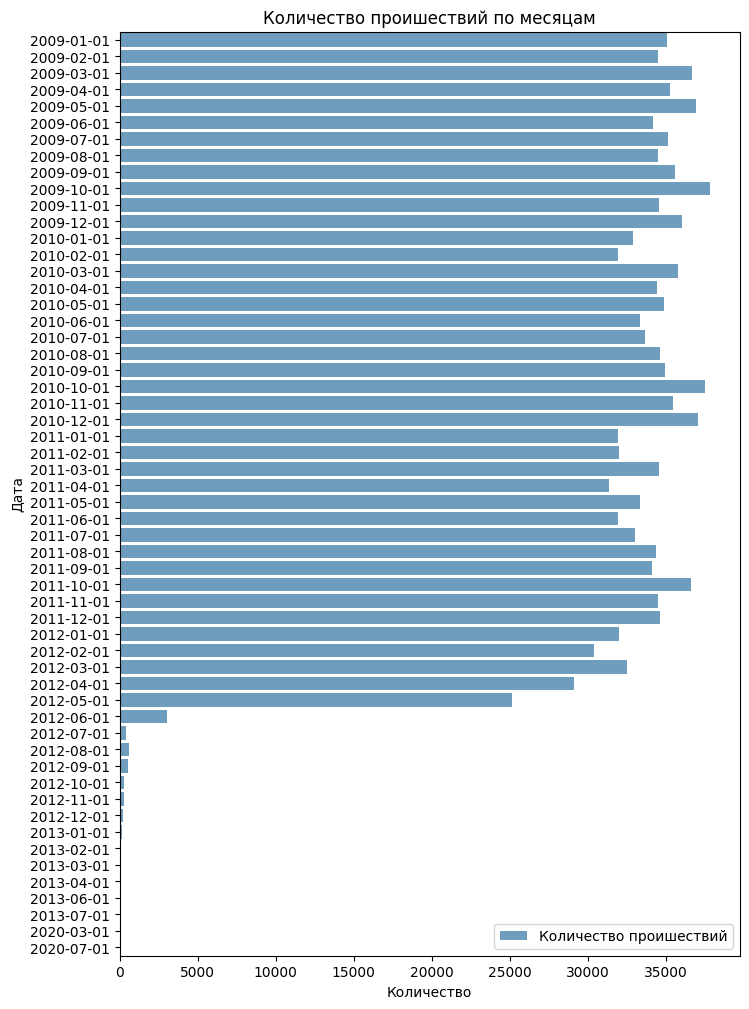

In [11]:
f, ax = plt.subplots(figsize=(8, 12))

sns.barplot(data=time_series,
            x='count',
            y='month',
            alpha=0.7, label = 'Количество проишествий', ax=ax)
ax.legend(loc="lower right")
ax.set(xlabel="Количество",
       ylabel="Дата")
plt.title("Количество проишествий по месяцам")
plt.show()

Можем сделать вывод, что начиная с *июня 2012 года* количество данных о происществиях резко снизилось. Поэтому, чтобы сгрупировать данные по всем месяцам и узнать, в какие месяцы происходит наибольшее количество аварий, будем использовать промежуток ***с января 2009 года по июнь 2012*** для достижения максимально объективной оценки.

Пропишем запрос на выгрузку этих данных, а также создадим словарь для месяцев и заменим им индексы.

In [12]:
collisions_filtered = collisions[
    (collisions['collision_date'] >= '2009-01-01') & 
    (collisions['collision_date'] <= '2012-06-01')
].copy()

monthly_counts = (collisions_filtered
    .assign(month_start=collisions_filtered['collision_date'].dt.to_period('M').dt.to_timestamp()) 
    .groupby('month_start', as_index=False)
    .size()
    .rename(columns={'size': 'count'})
)


time_series = (monthly_counts
    .assign(month_num=monthly_counts['month_start'].dt.month) 
    .groupby('month_num', as_index=False)
    .agg(accidents_mean=('count', 'mean'))
    .rename(columns={'month_num': 'accidents_date'})
    .sort_values('accidents_date')
)

month_list = {1 : 'Январь',
              2 : 'Февраль',
              3 : 'Март',
              4 : 'Апрель',
              5 : 'Май',
              6 : 'Июнь',
              7 : 'Июль',
              8 : 'Август',
              9 : 'Сентябрь',
              10 : 'Октябрь',
              11 : 'Ноябрь',
              12 : 'Декабрь'}

time_series = time_series.sort_values(by='accidents_date').reset_index(drop=True)

time_series['accidents_date'] = time_series['accidents_date'].replace(month_list)

time_series = time_series.set_index('accidents_date')
time_series

,accidents_mean
accidents_date,
Январь,32975.00
Февраль,32187.50
Март,34883.50
Апрель,32543.75
Май,32579.00
Июнь,25005.50
Июль,33945.00
Август,34489.00
Сентябрь,34883.00


Построим наглядный график.

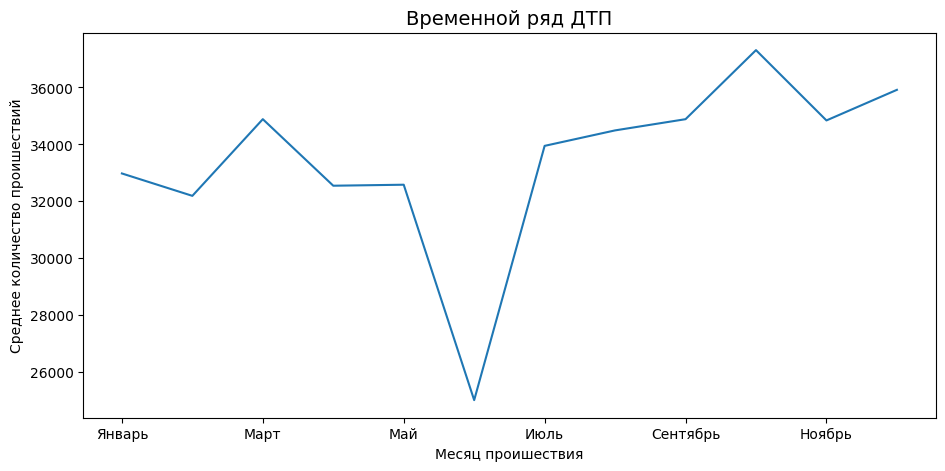

In [13]:
time_series['accidents_mean'].plot(kind='line', figsize=(11, 5))
plt.title('Временной ряд ДТП', fontsize=14)
plt.xlabel('Месяц проишествия')
plt.ylabel('Среднее количество проишествий')
plt.show()

### Вывод

По нашему графику можем смело сделать вывод, что **наибольшое** количество аварий происходит в ***октябре***, а **наименьшее** - в ***июне***. Такая зависимость может быть связана с ухудшением погодных условий и освещаемости в осенние месяцы, в течение которых и наблюдается активный рост аварий.

### Задачи 

Выполнил следующие аналитические задачи:

* провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП;
* автомобили с каким типом кузова чаще получают серьезные повреждения при аварии;
* найти самые частые причины ДТП.

### Анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП

В данной задаче нам необходимо:


*   создать запрос, где будет отражено количество происшествий, которые привели к различным повреждениям, сгруппированные по состояниям дорог;
*   построить наглядный график для выбранных данных;
*   сделать вывод и выяснить, сильно ли влияет состояние дорог на серьёзность последствий ДТП.



In [14]:
car_case_ids = parties[parties['party_type'] == 'car']['case_id'].unique()

filtered = collisions[collisions['case_id'].isin(car_case_ids)]

damage_road_condition = (
    filtered
    .groupby(['road_surface', 'collision_damage'], as_index=False,  dropna=False)
    .size()
    .rename(columns={'size': 'count'})
    .sort_values(['road_surface', 'count'])
    .reset_index(drop=True)
)

damage_road_condition

,road_surface,collision_damage,count
0,dry,fatal,9746
1,dry,severe damage,26965
2,dry,middle damage,147189
3,dry,scratch,306610
4,dry,small damage,742447
5,slippery,fatal,12
6,slippery,severe damage,60
7,slippery,middle damage,225
8,slippery,scratch,304
9,slippery,small damage,758


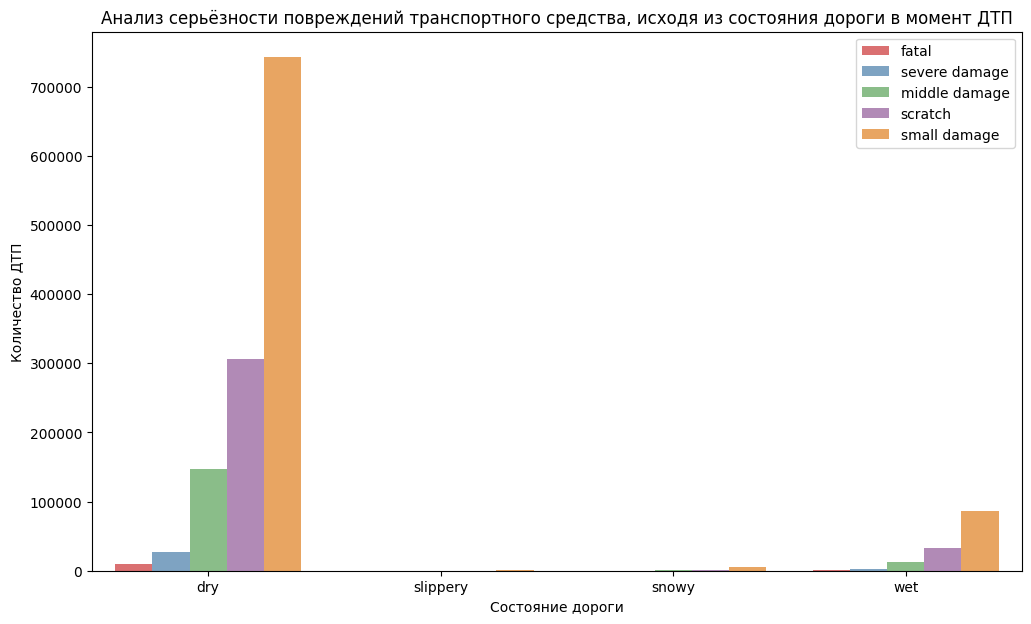

In [15]:
f, ax = plt.subplots(figsize=(12, 7))

sns.barplot(data = damage_road_condition,
            x = 'road_surface',
            y = 'count',
            hue  = 'collision_damage',
            palette = "Set1",
            alpha=0.7)
ax.legend(loc="upper right")
ax.set(xlabel="Состояние дороги",
       ylabel="Количество ДТП")
plt.title("Анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП")
plt.show()

### Вывод

Во всех группах состояния дорожного покрытия мы можем заметить крайне схожые паттерны распределения повреждений. Больше всего мелких повреждений, за ними идет серьезное повреждение, потом царапины, среднее повреждение и меньше всего фатальных.

В ходе анализа также выяснилось, что большая часть происшествий приходится на сухие дороги, а наименьшая - на скользкие, грязные и маслянистые.

### Автомобили с каким типом кузова чаще получают серьезные повреждения при авариях

В данной задаче нам необходимо:


*   создать запрос, где будет отражено количество и процентное соотношение происшествий, которые привели к различным повреждениям, сгруппированные по типу кузова;
*   построить наглядный график для выбранных данных;
*   сделать вывод и выяснить, каким образом зависит серьёзность последствий ДТП от типа кузова автомобиля.



In [16]:
merged = pd.merge(collisions[['case_id', 'collision_damage']], vehicles[['case_id', 'vehicle_type']], on='case_id', how='inner')

count_vehicle_types = merged.groupby(['vehicle_type'], as_index=False,  dropna=False).size()

damage_road_condition = (
    merged
    .groupby(['collision_damage', 'vehicle_type'], as_index=False,  dropna=False)
    .size()
    .rename(columns={'size': 'count'})
    .sort_values(['vehicle_type', 'collision_damage'])
    .reset_index(drop=True)
)
damage_road_condition = pd.merge(damage_road_condition, count_vehicle_types, on='vehicle_type', how='inner')
damage_road_condition['prcnt'] = damage_road_condition['count'] / damage_road_condition['size']
car_crash = damage_road_condition.drop(columns=['size'])
car_crash

,collision_damage,vehicle_type,count,prcnt
0,fatal,coupe,8916,0.020136
1,middle damage,coupe,131486,0.296956
2,scratch,coupe,278571,0.629141
3,severe damage,coupe,23807,0.053767
4,fatal,hatchback,2786,0.061103
5,middle damage,hatchback,17576,0.385481
6,scratch,hatchback,19355,0.424498
7,severe damage,hatchback,5878,0.128918
8,fatal,minivan,527,0.012256
9,middle damage,minivan,22046,0.512698


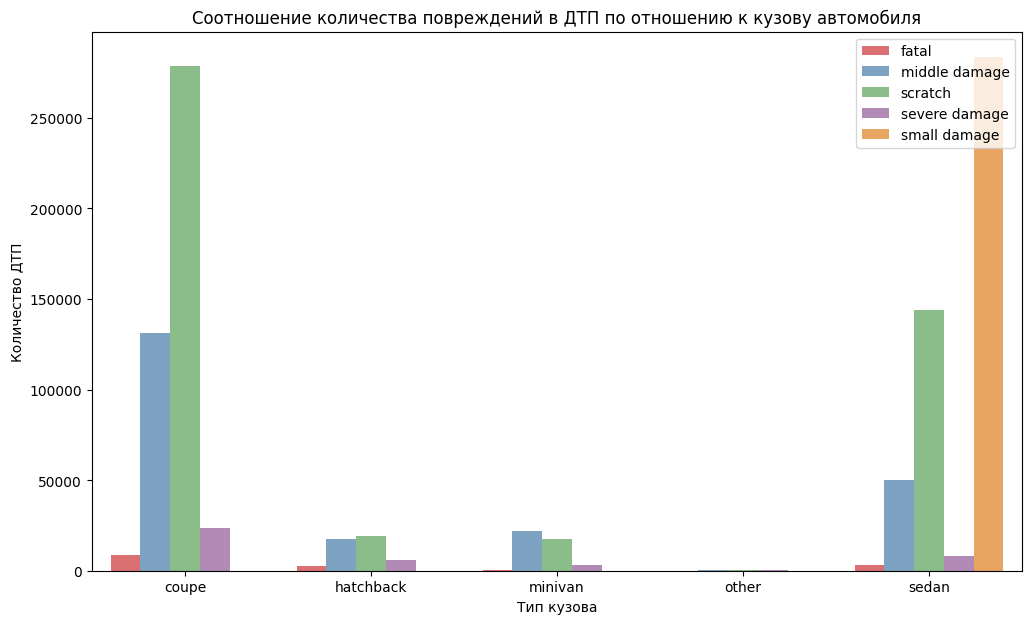

In [17]:
f, ax = plt.subplots(figsize=(12, 7))

sns.barplot(data = car_crash,
            x = 'vehicle_type',
            y = 'count',
            hue = 'collision_damage',
            palette = "Set1",
            alpha=0.7)
ax.legend(loc="upper right")
ax.set(xlabel="Тип кузова",
       ylabel="Количество ДТП")
plt.title("Соотношение количества повреждений в ДТП по отношению к кузову автомобиля")
plt.show()

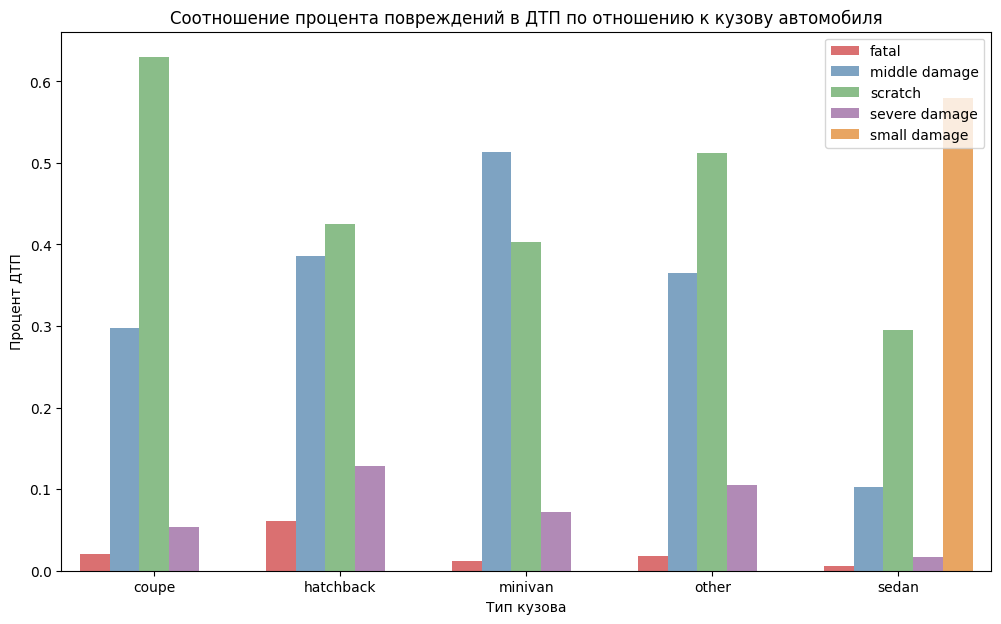

In [18]:
f, ax = plt.subplots(figsize=(12, 7))

sns.barplot(data = car_crash,
            x = 'vehicle_type',
            y = 'prcnt',
            hue = 'collision_damage',
            palette = "Set1",
            alpha=0.7)
ax.legend(loc="upper right")
ax.set(xlabel="Тип кузова",
       ylabel="Процент ДТП")
plt.title("Соотношение процента повреждений в ДТП по отношению к кузову автомобиля")
plt.show()

### Вывод

Мы построили два графика: в первом за основу взяли количество происшествий внутри группы, а во втором - процентное соотношения аварий.

В количественном отношении во всех категориях кроме легких повреждений лидируют машины с типом кузова ***купе***.

В процентном соотношении внутри групп лидеры поменялись. Категория Other слишком маленькая, ее можно не рассматривать. В категории "Царапины" лидируют Купе. В категории "Средние повреждения" лидируют Минивены, а в категории "Не подлежит восстановлению", "Серьезные повреждения" - лидер Хачбек. В категории кузова Седан у нас имеется пятая категория "Малые повреждения" и адекватно сравнивать седаны с другими типами кузовов становится проблематично.

## Проведём анализ важности факторов ДТП

Пропишем запрос, который сформирует необходимый нам датасет по условиям заказчика:

* выберем тип виновника — только машина (car);
* возьмём случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина);
* для моделирования возьмём данные только за 2012 год.

In [42]:
collisions_2012_not_scratch = collisions[(pd.to_datetime(collisions['collision_date']).dt.year == 2012)
    & (collisions['collision_damage'] != 'scratch')]
parties_cars = parties[parties['party_type'] == 'car']

merged_v_and_p = pd.merge(parties_cars, vehicles, on=['case_id', 'party_number'], how='inner')
data_impotant = pd.merge(merged_v_and_p, collisions_2012_not_scratch, on=['case_id'], how='inner')
data_impotant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id_x                         56248 non-null  int64         
 1   case_id                      56248 non-null  int64         
 2   party_number                 56248 non-null  int64         
 3   party_type                   56248 non-null  object        
 4   at_fault                     56248 non-null  int64         
 5   insurance_premium            55701 non-null  float64       
 6   party_sobriety               55376 non-null  object        
 7   party_drug_physical          2857 non-null   object        
 8   cellphone_in_use             51777 non-null  float64       
 9   id_y                         56248 non-null  int64         
 10  vehicle_type                 56248 non-null  object        
 11  vehicle_transmission         55389 non-nu

Далее рассмотрим каждый столбец и проанализуруем, влияет ли он на вероятность ДТП.

| Название фактора | Описание | Влияние на вероятность ДТП | Вывод |
|------------------|----------|----------------------------|-------|
|case_id| Идентификационный номер в базе данных|не влияет  |удаляем|
|county_city_location|Номер географических районов, где произошло ДТП|может повлиять, но названия информативнее|удаляем|
|county_location|Названия географических районов, где произошло ДТП|может повлиять|оставляем|
|distance|Расстояние от главной дороги (метры)|навряд ли влияет|удаляем|
|direction|Направление движения|может повлиять|оставляем|
|intersection|Является ли место происшествие перекрёстком|влияет|оставляем|
|weather_1|Погода|влияет|оставляем|
|location_type|Тип дороги|влияет|оставляем|
|collision_damage|Серьёзность происшествия|не влияет|удаляем|
|party_count|Количество участников|не влияет|удаляем|
|primary_collision_factor|Основной фактор аварии|не влияет|удаляем|
|pcf_violation_category|Категория нарушения|не влияет|удаляем|
|type_of_collision|Тип аварии|не влияет|удаляем|
|motor_vehicle_involved_with|Дополнительные участники ДТП|не влияет|удаляем|
|road_surface|Состояние дороги|влияет|оставляем|
|road_condition_1|Дорожное состояние|влияет|оставляем|
|lighting|Освещение|влияет|оставляем|
|control_device|Контролирующее устройство, система ABS|может повлиять|оставляем|
|collision_date|Дата происшествия|объяснено другими факторами|удаляем|
|collision_time|Время происшествия|объяснено другими факторами|удаляем|
|id|Индекс текущей таблицы|не влияет|удаляем|
|party_number|Номер участника происшествия|не влияет|удаляем|
|vehicle_type|Тип кузова|влияет|оставляем|
|vehicle_transmission|Тип КПП|навряд ли влияет|удаляем|
|vehicle_age|Возраст автомобиля (в годах)|условие заказчика|оставляем|
|party_type|Тип участника происшествия|оставили только машины, поэтому не влияет|удаляем|
|at_fault|Виновность участника|целевой признак, влияет|оставляем|
|insurance_premium|Сумма страховки (тыс. $)|не влияет|удаляем|
|party_sobriety|Трезвость участника|влияет|оставляем|
|party_drug_physical|Состояние участника: физическое или с учётом принятых лекарств|влияет|оставляем|
|cellphone_in_use|Наличие телефона в автомобиле (возможности разговаривать по громкой связи)|влияет|оставляем|

Удалим ненужные факторы из датафрейма.

In [43]:
data_impotant.drop(columns=[
    'case_id', 'county_city_location', 'distance', 'collision_damage', 'party_count', 
    'primary_collision_factor', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 
    'collision_date', 'collision_time', 'party_number', 'vehicle_transmission', 'party_type', 'id_x', 'id_y', 'insurance_premium'
], inplace=True, errors='ignore')

Проведём проверки на явные дубликаты, избавимся от них и сразу же проверим результат.

In [44]:
data_impotant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   at_fault             56248 non-null  int64  
 1   party_sobriety       55376 non-null  object 
 2   party_drug_physical  2857 non-null   object 
 3   cellphone_in_use     51777 non-null  float64
 4   vehicle_type         56248 non-null  object 
 5   vehicle_age          54554 non-null  float64
 6   county_location      56248 non-null  object 
 7   direction            43230 non-null  object 
 8   intersection         56073 non-null  float64
 9   weather_1            56080 non-null  object 
 10  location_type        25932 non-null  object 
 11  road_surface         55900 non-null  object 
 12  road_condition_1     55999 non-null  object 
 13  lighting             56094 non-null  object 
 14  control_device       56033 non-null  object 
dtypes: float64(3), int64(1), object(11)


In [45]:
data_impotant.duplicated().sum()

19646

In [46]:
data_impotant.drop_duplicates(inplace=True, ignore_index=True)
data_impotant.duplicated().sum()

0

Переименуем названия столбцов `weather_1` и `road_condition_1`, удалив ненужные символы.

In [47]:
data_impotant.rename(columns={'weather_1':'weather', 'road_condition_1':'road_condition'}, inplace=True)

Загрузим информацию о датасете:

In [48]:
get_data_info(data_impotant)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36602 entries, 0 to 36601
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   at_fault             36602 non-null  int64  
 1   party_sobriety       35740 non-null  object 
 2   party_drug_physical  2799 non-null   object 
 3   cellphone_in_use     32732 non-null  float64
 4   vehicle_type         36602 non-null  object 
 5   vehicle_age          35396 non-null  float64
 6   county_location      36602 non-null  object 
 7   direction            28616 non-null  object 
 8   intersection         36431 non-null  float64
 9   weather              36434 non-null  object 
 10  location_type        16833 non-null  object 
 11  road_surface         36262 non-null  object 
 12  road_condition       36355 non-null  object 
 13  lighting             36448 non-null  object 
 14  control_device       36392 non-null  object 
dtypes: float64(3), int64(1), object(11)


None

(36602, 15)

,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_age,county_location,direction,intersection,weather,location_type,road_surface,road_condition,lighting,control_device
0,1,"had been drinking, under influence",under drug influence,0.0,sedan,3.0,san benito,NaN,1.0,clear,NaN,dry,loose material,dark with street lights,functioning
1,1,had not been drinking,NaN,0.0,coupe,13.0,san diego,east,0.0,clear,NaN,dry,normal,daylight,none
2,0,had not been drinking,NaN,0.0,sedan,3.0,los angeles,north,0.0,clear,NaN,dry,normal,daylight,none
3,1,had not been drinking,NaN,0.0,coupe,11.0,los angeles,south,0.0,clear,highway,dry,normal,daylight,none
4,1,"had been drinking, under influence",NaN,NaN,coupe,6.0,alameda,NaN,0.0,clear,ramp,dry,normal,dark with street lights,none


at_fault                   0
party_sobriety           862
party_drug_physical    33803
cellphone_in_use        3870
vehicle_type               0
vehicle_age             1206
county_location            0
direction               7986
intersection             171
weather                  168
location_type          19769
road_surface             340
road_condition           247
lighting                 154
control_device           210
dtype: int64

,count,mean,std,min,25%,50%,75%,max
at_fault,36602.0,0.551473,0.497350,0.0,0.0,1.0,1.0,1.0
cellphone_in_use,32732.0,0.029421,0.168985,0.0,0.0,0.0,0.0,1.0
vehicle_age,35396.0,5.139762,3.415402,0.0,3.0,4.0,7.0,161.0
intersection,36431.0,0.203453,0.402572,0.0,0.0,0.0,0.0,1.0


Из полученной информации можем заметить, что данные необходимо обработать, так как присутствует множество пропусков. Просто так удалить мы их не можем, так как данных после выборки осталось не так уж и много. Поэтому с каждым фактором разберёмся в отдельности и посмотрим, что можно улучшить.

Проверим таргет на дисбаланс классов.

In [49]:
data_impotant['at_fault'].value_counts(normalize = True)

at_fault
1    0.551473
0    0.448527
Name: proportion, dtype: float64

Небольшой дисбаланс присутствует, но он не является критичным, поэтому корректировать его нет необходимости.

## Предобработка данных

Приступим к предобработке данных.

### county_location

Просмотрим уникальные значения в столбце `county_location` на признак неявный дубликатов.

In [50]:
data_impotant['county_location'].unique()

array(['san benito', 'san diego', 'los angeles', 'alameda', 'nevada',
       'el dorado', 'san bernardino', 'orange', 'tulare', 'san francisco',
       'sacramento', 'santa clara', 'solano', 'placer', 'san luis obispo',
       'ventura', 'madera', 'riverside', 'humboldt', 'napa', 'fresno',
       'kings', 'santa barbara', 'sutter', 'contra costa', 'shasta',
       'colusa', 'santa cruz', 'san mateo', 'sonoma', 'monterey',
       'stanislaus', 'san joaquin', 'kern', 'imperial', 'lassen',
       'tehama', 'siskiyou', 'mendocino', 'sierra', 'marin', 'yuba',
       'plumas', 'merced', 'tuolumne', 'butte', 'yolo', 'mariposa',
       'glenn', 'del norte', 'calaveras', 'amador', 'inyo', 'lake',
       'trinity', 'mono', 'alpine', 'modoc'], dtype=object)

Неявных дубликатов не обнаружено, пропусков в столбце нет.

### direction

Посмотрим уникальные значения фактора `direction`, чтобы также избежать неявных дубликатов.

In [51]:
data_impotant['direction'].value_counts(dropna=False)

direction
NaN      7986
north    7953
south    7754
west     6512
east     6397
Name: count, dtype: int64

В этом столбце достаточно много пропущенных значений, чтобы их удалять, поэтому заменим их на значение **unknown** и проверим результат.

In [52]:
data_impotant['direction'] = data_impotant['direction'].fillna('unknown')
data_impotant['direction'].value_counts(dropna=False)

direction
unknown    7986
north      7953
south      7754
west       6512
east       6397
Name: count, dtype: int64

### weather

In [53]:
data_impotant['weather'].value_counts(dropna=False)

weather
clear      26650
cloudy      7338
raining     2068
fog          178
NaN          168
snowing      155
other         34
wind          11
Name: count, dtype: int64

В факторе `weather` есть значение *other*, к которому можем отнести наши пропуски, чтобы не удалять их. Также к этой категории отнесём значение wind, так как она слишком мала и может ухудшить обучение модели. Заменим и проверим результат.

In [54]:
data_impotant['weather'] = data_impotant['weather'].fillna('other')
data_impotant['weather'] = data_impotant['weather'].replace('wind', 'other')
data_impotant['weather'].value_counts(dropna=False)

weather
clear      26650
cloudy      7338
raining     2068
other        213
fog          178
snowing      155
Name: count, dtype: int64

### location_type

In [55]:
data_impotant['location_type'].value_counts(dropna=False)

location_type
NaN             19769
highway         12745
ramp             2836
intersection     1252
Name: count, dtype: int64

В данном столбце огромнейшее количество пропусков. Судя по остальным категориям, оставшаяся - просто аварии на дороге, проставим категорию **road**.

In [56]:
data_impotant['location_type'] = data_impotant['location_type'].fillna('road')

In [57]:
data_impotant['location_type'].value_counts(dropna=False)

location_type
road            19769
highway         12745
ramp             2836
intersection     1252
Name: count, dtype: int64

### road_surface

In [58]:
data_impotant['road_surface'].value_counts(dropna=False)

road_surface
dry         30928
wet          4938
snowy         353
NaN           340
slippery       43
Name: count, dtype: int64

Соединим категории *snowy* и *slippery*, так как обе они говорят о скольжении. NaN значения отнесём к сухим дорогам.

In [59]:
data_impotant['road_surface'] = data_impotant['road_surface'].replace('slippery', 'snowy')
data_impotant['road_surface'] = data_impotant['road_surface'].fillna('dry')
data_impotant['road_surface'].value_counts(dropna=False)

road_surface
dry      31268
wet       4938
snowy      396
Name: count, dtype: int64

### road_condition

In [60]:
data_impotant['road_condition'].value_counts(dropna=False)

road_condition
normal            34479
construction        956
NaN                 247
obstruction         245
other               227
holes               217
loose material      128
reduced width        71
flooded              32
Name: count, dtype: int64

В факторе `road_condition` есть значение *other*, к которому можем отнести наши пропуски, чтобы не удалять их. Отнесём к нему также значение *flooded*. Заменим и проверим результат.

In [61]:
data_impotant['road_condition'] = data_impotant['road_condition'].fillna('other')
data_impotant['road_condition'] = data_impotant['road_condition'].replace('flooded', 'other')
data_impotant['road_condition'].value_counts(dropna=False)

road_condition
normal            34479
construction        956
other               506
obstruction         245
holes               217
loose material      128
reduced width        71
Name: count, dtype: int64

### lighting

In [62]:
data_impotant['lighting'].value_counts(dropna=False)

lighting
daylight                                   22302
dark with street lights                     7962
dark with no street lights                  4437
dusk or dawn                                1615
NaN                                          154
dark with street lights not functioning      132
Name: count, dtype: int64

В факторе `lighting` есть очень небольшая категория *dark with street lights not functioning*. Её можно объединить с *dark with no street lights*.

In [65]:
data_impotant['lighting'] = data_impotant['lighting'].replace('dark with street lights not functioning', 'dark with no street lights')
data_impotant['lighting'].value_counts(dropna=False)

lighting
daylight                      22302
dark with street lights        7962
dark with no street lights     4569
dusk or dawn                   1615
Name: count, dtype: int64

Избавляемся от пропусков в стобце `lighting`, так как их не очень много.

In [66]:
data_impotant = data_impotant.drop(data_impotant[data_impotant['lighting'].isna()].index)
data_impotant['lighting'].isna().sum()

0

### control_device

In [67]:
data_impotant['control_device'].value_counts(dropna=False)

control_device
none               24140
functioning        11977
NaN                  190
not functioning      113
obscured              28
Name: count, dtype: int64

В факторе `control_device` отображается наличие или отсутствие антиблокирующего устройства ABS (насколько я понял). Соответственно пропуски могут говорить о том, что ABS не было, но эту информацию не внесли. Поэтому пропуски отнесём к категории **none**. Также малочисленные категории *not functioning* и *obscured* по смыслу можно заменить на *none*.

In [68]:
data_impotant['control_device'] = data_impotant['control_device'].fillna('none')
data_impotant['control_device'] = data_impotant['control_device'].replace(['obscured', 'not functioning'], 'none')
data_impotant['control_device'].value_counts(dropna=False)

control_device
none           24471
functioning    11977
Name: count, dtype: int64

### vehicle_type

In [69]:
data_impotant['vehicle_type'].value_counts(dropna=False)

vehicle_type
sedan    22635
coupe    13810
other        3
Name: count, dtype: int64

В столбце `vehicle_type` категория *other* слишком малочислена, поэтому от неё лучше избавиться, чтобы улучшить качество модели.

In [70]:
data_impotant.drop(index=data_impotant[data_impotant['vehicle_type'] == 'other'].index, inplace=True)
data_impotant['vehicle_type'].value_counts(dropna=False)

vehicle_type
sedan    22635
coupe    13810
Name: count, dtype: int64

### vehicle_age

Заменим пропуски в столбце `vehicle_age` медианным значением после сплитования данных.

Построим график рспределения

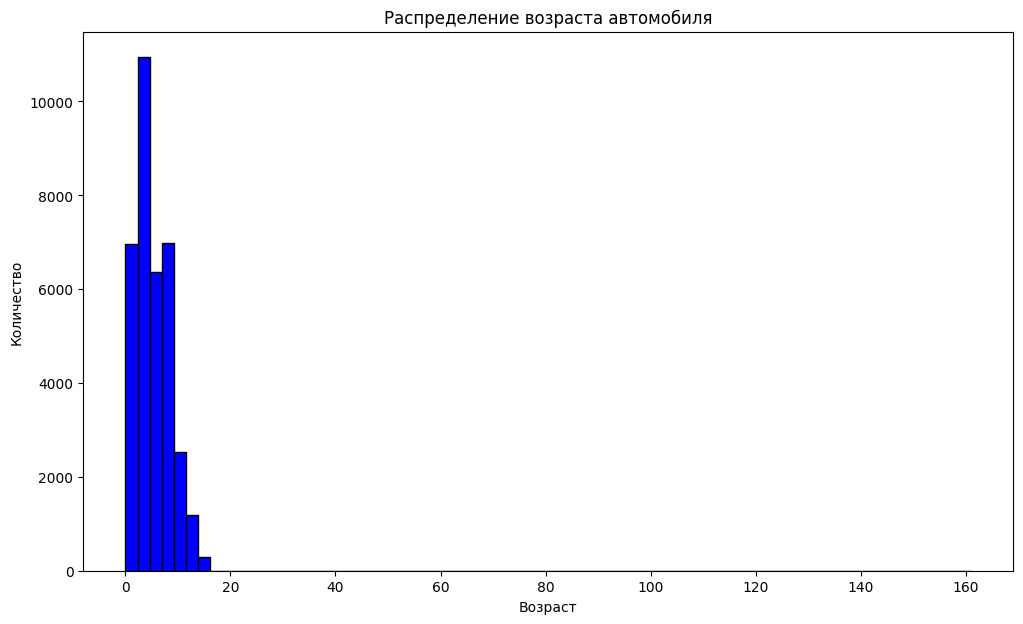

In [71]:
plt.figure(figsize = (12, 7))
plt.hist(data_impotant['vehicle_age'], color = 'blue', edgecolor = 'black', bins = 70)
plt.title('Распределение возраста автомобиля')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Видим, что присутствуют экстремально аномальные значения, избавимся от них после сплитования выборки.

### cellphone_in_use

Посмотрим на распредление в столбце `cellphone_in_use`.

In [72]:
data_impotant['cellphone_in_use'].value_counts(dropna=False)

cellphone_in_use
0.0    31641
NaN     3843
1.0      961
Name: count, dtype: int64

Пропуски заменим значением 0, так как они могут говорить об отсутствии телефона в автомобиле.

In [73]:
data_impotant['cellphone_in_use'] = data_impotant['cellphone_in_use'].fillna(0)

### intersection        

In [74]:
data_impotant['intersection'].value_counts(dropna=False)

intersection
0.0    28908
1.0     7367
NaN      170
Name: count, dtype: int64

отнесём NaN значения к отсутсвию перекрёстка.

In [75]:
data_impotant['intersection'] = data_impotant['intersection'].fillna(0)
data_impotant['intersection'].value_counts(dropna=False)

intersection
0.0    29078
1.0     7367
Name: count, dtype: int64

### party_drug_physical  

In [76]:
data_impotant['party_drug_physical'].value_counts(dropna=False)

party_drug_physical
NaN                      33653
G                         1195
under drug influence       845
sleepy/fatigued            386
not applicable             246
impairment - physical      120
Name: count, dtype: int64

Заменим нан значения на "normal", хотя, возможно, можно вообще удалить этот признак.

In [77]:
data_impotant['party_drug_physical'] = data_impotant['party_drug_physical'].fillna('normal')
data_impotant['party_drug_physical'].value_counts(dropna=False)

party_drug_physical
normal                   33653
G                         1195
under drug influence       845
sleepy/fatigued            386
not applicable             246
impairment - physical      120
Name: count, dtype: int64

### party_sobriety       

In [78]:
data_impotant['party_sobriety'].value_counts(dropna=False)

party_sobriety
had not been drinking                     29476
had been drinking, under influence         3866
impairment unknown                         1195
NaN                                         844
had been drinking, not under influence      562
had been drinking, impairment unknown       256
not applicable                              246
Name: count, dtype: int64

Объединим категории `not applicable`, `NaN` и `impairment unknown` в одну, также объдиним `had been drinking, impairment unknown` с `had been drinking, under influence` и `had been drinking, not under influence` с `had not been drinking`.

In [79]:
data_impotant['party_sobriety'] = data_impotant['party_sobriety'].fillna('impairment unknown')

data_impotant['party_sobriety'] = data_impotant['party_sobriety'].replace('not applicable', 'impairment unknown')
data_impotant['party_sobriety'] = data_impotant['party_sobriety'].replace('had been drinking, impairment unknown', 'had been drinking, under influence')
data_impotant['party_sobriety'] = data_impotant['party_sobriety'].replace('had been drinking, not under influence', 'had not been drinking')

data_impotant['party_sobriety'].value_counts(dropna=False)

party_sobriety
had not been drinking                 30038
had been drinking, under influence     4122
impairment unknown                     2285
Name: count, dtype: int64

### Train test split

Расзделим все факторы на числовые и категориальные и изменим их тип данных на соответствующий.

In [80]:
numeric = [
    'vehicle_age'          
]

category = [
    'cellphone_in_use', 'vehicle_type', 'intersection',
    'county_location', 'direction', 'weather', 'location_type', 'road_surface',
    'road_condition', 'lighting', 'control_device', 'party_drug_physical', 'party_sobriety'
]


data_impotant = data_impotant.astype({
    **{_:'object' for _ in category}
})

Делим нашу выборку на тренировочную и тестовую. Посмотрим на размерность выборок.

In [81]:
X = data_impotant.drop(['at_fault'], axis=1)
y = data_impotant['at_fault']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.25,
    random_state=42,
    stratify=y
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(27333, 14) (27333,)
(9112, 14) (9112,)


Далее приступим к удалению выбросов в столбцах с возрастом автомобиля и сразу же проверяем результат на размерности нашей обучающей выборки.

In [82]:
index_vehicle_age = X_train[X_train['vehicle_age'] > X_train['vehicle_age'].quantile(0.99)].index

In [83]:
X_train.drop(index=index_vehicle_age, inplace=True)
y_train.drop(index=index_vehicle_age, inplace=True)

print(X_train.shape, y_train.shape)

(27110, 14) (27110,)


Заполняем пропуски медианным значением в столбце `vehicle_age` по обучающей выборке.

In [84]:
median_vehical_age = X_train['vehicle_age'].median()

In [85]:
X_train['vehicle_age'] = X_train['vehicle_age'].fillna(median_vehical_age)
X_test['vehicle_age'] = X_test['vehicle_age'].fillna(median_vehical_age)
print(X_train['vehicle_age'].isna().sum())
print(X_test['vehicle_age'].isna().sum())

0
0


Теперь можем поменять тип данных на корректный.

In [86]:
X_train['vehicle_age'] = X_train['vehicle_age'].astype('int64')
X_test['vehicle_age'] = X_test['vehicle_age'].astype('int64')

In [87]:
get_data_info(X_train)

<class 'pandas.core.frame.DataFrame'>
Index: 27110 entries, 22041 to 27949
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   party_sobriety       27110 non-null  object
 1   party_drug_physical  27110 non-null  object
 2   cellphone_in_use     27110 non-null  object
 3   vehicle_type         27110 non-null  object
 4   vehicle_age          27110 non-null  int64 
 5   county_location      27110 non-null  object
 6   direction            27110 non-null  object
 7   intersection         27110 non-null  object
 8   weather              27110 non-null  object
 9   location_type        27110 non-null  object
 10  road_surface         27110 non-null  object
 11  road_condition       27110 non-null  object
 12  lighting             27110 non-null  object
 13  control_device       27110 non-null  object
dtypes: int64(1), object(13)
memory usage: 3.1+ MB


None

(27110, 14)

,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_age,county_location,direction,intersection,weather,location_type,road_surface,road_condition,lighting,control_device
22041,had not been drinking,normal,0.0,sedan,3,alameda,north,0.0,clear,road,dry,normal,dark with street lights,none
5875,had not been drinking,normal,0.0,sedan,4,san francisco,east,0.0,cloudy,highway,dry,normal,daylight,none
23742,had not been drinking,normal,0.0,coupe,13,nevada,north,0.0,cloudy,road,dry,normal,daylight,none
34813,"had been drinking, under influence",normal,0.0,sedan,8,kern,north,0.0,clear,road,dry,normal,daylight,none
21884,had not been drinking,normal,0.0,sedan,2,sacramento,south,0.0,raining,road,wet,normal,dark with street lights,functioning


party_sobriety         0
party_drug_physical    0
cellphone_in_use       0
vehicle_type           0
vehicle_age            0
county_location        0
direction              0
intersection           0
weather                0
location_type          0
road_surface           0
road_condition         0
lighting               0
control_device         0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
vehicle_age,27110.0,5.02453,3.060825,0.0,3.0,4.0,7.0,13.0


In [88]:
get_data_info(X_test)

<class 'pandas.core.frame.DataFrame'>
Index: 9112 entries, 33579 to 36047
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   party_sobriety       9112 non-null   object
 1   party_drug_physical  9112 non-null   object
 2   cellphone_in_use     9112 non-null   object
 3   vehicle_type         9112 non-null   object
 4   vehicle_age          9112 non-null   int64 
 5   county_location      9112 non-null   object
 6   direction            9112 non-null   object
 7   intersection         9112 non-null   object
 8   weather              9112 non-null   object
 9   location_type        9112 non-null   object
 10  road_surface         9112 non-null   object
 11  road_condition       9112 non-null   object
 12  lighting             9112 non-null   object
 13  control_device       9112 non-null   object
dtypes: int64(1), object(13)
memory usage: 1.0+ MB


None

(9112, 14)

,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_age,county_location,direction,intersection,weather,location_type,road_surface,road_condition,lighting,control_device
33579,"had been drinking, under influence",normal,0.0,coupe,4,yuba,south,0.0,clear,road,dry,normal,dark with no street lights,none
31319,had not been drinking,normal,0.0,sedan,5,santa clara,north,0.0,clear,road,dry,normal,daylight,none
17534,had not been drinking,normal,0.0,sedan,1,fresno,south,0.0,clear,road,dry,normal,dark with street lights,none
33050,impairment unknown,under drug influence,0.0,coupe,2,orange,north,0.0,clear,road,dry,normal,daylight,none
2560,had not been drinking,normal,0.0,coupe,8,san bernardino,south,0.0,clear,highway,dry,normal,daylight,none


party_sobriety         0
party_drug_physical    0
cellphone_in_use       0
vehicle_type           0
vehicle_age            0
county_location        0
direction              0
intersection           0
weather                0
location_type          0
road_surface           0
road_condition         0
lighting               0
control_device         0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
vehicle_age,9112.0,5.085711,3.175371,0.0,3.0,4.0,7.0,17.0


Уже видим результаты в виде отсутствия пропусков и корректных типов данных.

Проверяем размерность выборок после деления и соотношение положительных ответов.

In [89]:
print(f'Доля тренировочных признаков: {X_train.shape[0]/data_impotant.shape[0]:.2f}')
print(f'Доля тренировочных целей: {y_train.shape[0]/data_impotant.shape[0]:.2f}')
print(f'Доля тестовых признаков: {X_test.shape[0]/data_impotant.shape[0]:.2f}')
print(f'Доля тестовых целей: {y_test.shape[0]/data_impotant.shape[0]:.2f}')
print(f'Доля положительных целей на тренировочных данных: {y_train.astype("int").mean():.2f}')
print(f'Доля положительных целей на тестовых данных: {y_test.astype("int").mean():.2f}')

Доля тренировочных признаков: 0.74
Доля тренировочных целей: 0.74
Доля тестовых признаков: 0.25
Доля тестовых целей: 0.25
Доля положительных целей на тренировочных данных: 0.55
Доля положительных целей на тестовых данных: 0.55


### Вывод

Мы подготовили набор данных на основе требований заказчика. Проанализировали все факторы на предмет того, насколько они влияют на вероятность ДТП.

Обработали данные: убрали аномалии, почистили или заполнили пропуски, где это возможно, избавились дубликатов и поменяли типы данных на более рациональные.Также поделили выборку на тренировочную и тестовую.

Можно переходить к работе с моделями машинного обучения.

## Создание модели для оценки водительского риска

Будем решать задачу классификации на четырёх типах моделей - `LogisticRegression`, `RandomForestClassifier`, `LightGBM`. Но в первую очередь построим *baseline* на основе `DummyClassifier`. Это будет наша отправная точка для сравнения и улучшения.

При решении задачи классификации есть три основных метрики, которые мы используем для оценки качества модели:

1. **Precision**: процент правильных положительных прогнозов по отношению к общему количеству положительных прогнозов.

2. **Recall**: процент правильных положительных прогнозов по отношению к общему количеству фактических положительных результатов.

3. **F1-мера**: средневзвешенное гармоническое значение точности и полноты. Чем ближе к 1, тем лучше модель.

Используя эти три показателя, мы можем понять, насколько хорошо данная модель классификации способна предсказывать результаты. Мы воспользуемся инструментом из библиотеки sklearn для генерации всех трех этих показателей - ***функция classification_report()***. Но за основу возьмём **F1-метрику**, так как она будет более объективной и показательной.

### DummyClassifier

Обучим `DummyClassifier` и посмотрим на метрики, от которых будем отталкиваться.

In [90]:
%%time

model_dc = DummyClassifier(strategy='most_frequent')
model_dc.fit(X_train, y_train)
prediction_dc = model_dc.predict(X_test)

CPU times: total: 15.6 ms
Wall time: 3 ms


In [91]:
cr_dc = classification_report(
    y_test, prediction_dc,
    output_dict=True, zero_division=0
)

results = {} # словарь со сводными результатами для всех моделей
results['Dummy Classifier (most frequent)'] = cr_dc['weighted avg']
del results['Dummy Classifier (most frequent)']['support']

pd.DataFrame(cr_dc).round(decimals=3)

,0,1,accuracy,macro avg,weighted avg
precision,0.0,0.552,0.552,0.276,0.305
recall,0.0,1.000,0.552,0.500,0.552
f1-score,0.0,0.711,0.552,0.356,0.393
support,4082.0,5030.000,0.552,9112.000,NaN


Как мы и ожидали, получаем плохой результат. Переходим далее к модели логистической регрессии.

### LogisticRegression

Создадим трансформер для различных колонок, в случае с `LogisticRegression` к категориальным применим *OHE*, к числовым - *StandardScaler*.

In [92]:
linear_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='uint8',
            drop='first',
            handle_unknown='ignore'
        ), make_column_selector(dtype_include='object')
    ),
    (
        StandardScaler(
        ), make_column_selector(dtype_include='int64')
    ),
    remainder='passthrough'
)

Соберём pipeline для `LogisticRegression`.

In [93]:
pipe_lr = make_pipeline(
    linear_transformer,
    LogisticRegression(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
)

Зададим сетку параметров для перебора и создадим функцию *GridSerachCV*.

In [94]:
metrics = ['precision', 'recall', 'f1']

param_grid = {
    'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__C':[.001, .01],
    'logisticregression__max_iter':[500, 1000]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring=metrics,
    refit='f1',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

Обучим модель и посмотрим на лучшие гиперпараметры.

In [95]:
%time gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


CPU times: total: 5.08 s
Wall time: 33.7 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'logisticregression__C': [0.001, 0.01], 'logisticregression__max_iter': [500, 1000], 'logisticregression__solver': ['newton-cg', 'lbfgs', ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['precision', 'recall', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'f1'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 

In [96]:
gs_lr.best_params_

{'logisticregression__C': 0.001,
 'logisticregression__max_iter': 500,
 'logisticregression__solver': 'lbfgs'}

Посмотрим резальтат всех трёх метрик

In [97]:
cv_results = pd.DataFrame(gs_lr.cv_results_)
best_result_lr = cv_results[['mean_test_precision', 'mean_test_recall', 'mean_test_f1']].iloc[gs_lr.best_index_]
best_result_lr

mean_test_precision    0.711905
mean_test_recall       0.530112
mean_test_f1           0.607679
Name: 1, dtype: float64

Результат значительно вырос по сравнению с `DummyClassifier`. Таким же образом пройдёмся по каждой модели и соберём результаты в общую таблицу для анализа.

Запишем результат в общую таблицу.

In [98]:
results['Logistic Regression'] = best_result_lr

### RandomForestClassifier

Для модели `RandomForestClassifier` заменим кодирование категориальных признаков на метод *OrdinalEncoder*.

In [99]:
ensemble_transformer = make_column_transformer(
    (
        OrdinalEncoder(
            dtype='int16',
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), make_column_selector(dtype_include=['object'])
    ),
    remainder='passthrough'
)

In [100]:
pipe_rf = make_pipeline(
    ensemble_transformer,
    RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced',
        verbose=0
    )
)

In [101]:
param_grid = {
    'randomforestclassifier__n_estimators':np.arange(100, 151, 50),
    'randomforestclassifier__max_depth':np.arange(1, 10, 2),
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring=metrics,
    refit='f1',
    n_jobs=-1,
    verbose=1
)

In [102]:
%time gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 7.61 s
Wall time: 41.2 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'randomforestclassifier__max_depth': array([1, 3, 5, 7, 9]), 'randomforestclassifier__n_estimators': array([100, 150])}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['precision', 'recall', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'f1'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time f

In [103]:
gs_rf.best_params_

{'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 150}

In [104]:
cv_results_rf = pd.DataFrame(gs_rf.cv_results_)
best_result_rf = cv_results_rf[['mean_test_precision', 'mean_test_recall', 'mean_test_f1']].iloc[gs_rf.best_index_]
best_result_rf

mean_test_precision    0.768964
mean_test_recall       0.474099
mean_test_f1           0.586502
Name: 9, dtype: float64

In [105]:
results['Random Forest Classifier'] = best_result_rf

Precision вырос, хотя остальные метрику упали. Переходим к `LightGBM`.

### LightGBM

In [106]:
pipe_gbm = make_pipeline(
    ensemble_transformer,
    lgb.LGBMClassifier(
        objective='binary',
        metric='f1',
        n_jobs=-1,
        verbosity=-1,
        random_state=42
    )
)

In [107]:
param_grid = {
    'lgbmclassifier__max_depth':[-1, 10, 20],
    'lgbmclassifier__num_leaves':[10, 31],
    'lgbmclassifier__learning_rate':[.1, .5]
}

gs_gbm = GridSearchCV(
    pipe_gbm,
    param_grid,
    scoring=metrics,
    refit='f1',
    n_jobs=-1,
    verbose=1
)

In [108]:
%time gs_gbm.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 3.75 s
Wall time: 19.7 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...rbosity=-1))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'lgbmclassifier__learning_rate': [0.1, 0.5], 'lgbmclassifier__max_depth': [-1, 10, ...], 'lgbmclassifier__num_leaves': [10, 31]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['precision', 'recall', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'f1'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computati

In [109]:
gs_gbm.best_params_

{'lgbmclassifier__learning_rate': 0.1,
 'lgbmclassifier__max_depth': -1,
 'lgbmclassifier__num_leaves': 10}

In [110]:
cv_results_gbm = pd.DataFrame(gs_gbm.cv_results_)
best_result_gbm = cv_results_gbm[['mean_test_precision', 'mean_test_recall', 'mean_test_f1']].iloc[gs_gbm.best_index_]
best_result_gbm

mean_test_precision    0.702966
mean_test_recall       0.606911
mean_test_f1           0.651303
Name: 0, dtype: float64

In [111]:
results['Light GBM'] = best_result_gbm

Переименуем метрики у модели `Dummy Classifier` в общей таблице.

In [112]:
results['Dummy Classifier (most frequent)']['mean_test_precision'] = results['Dummy Classifier (most frequent)']['precision']
del results['Dummy Classifier (most frequent)']['precision']
results['Dummy Classifier (most frequent)']['mean_test_recall'] = results['Dummy Classifier (most frequent)']['recall']
del results['Dummy Classifier (most frequent)']['recall']
results['Dummy Classifier (most frequent)']['mean_test_f1'] = results['Dummy Classifier (most frequent)']['f1-score']
del results['Dummy Classifier (most frequent)']['f1-score']

Мы провели обучение и замер метрик для каждой из моделей. Выведем общую таблицу для сравнения результатов.

In [113]:
pd.DataFrame(results).round(decimals=3).transpose()

,mean_test_precision,mean_test_recall,mean_test_f1
Dummy Classifier (most frequent),0.305,0.552,0.393
Logistic Regression,0.712,0.530,0.608
Random Forest Classifier,0.769,0.474,0.587
Light GBM,0.703,0.607,0.651


Из представленных результатов видим, что лучше всех с нашей задачей по f1 и recall метрикам справилась модель `Light GBM`. Проигрывает только по точности другим моделям, но за основу сравнения берём f1.

## Проверка лучшей модели в работе

Передадим нашей лучшей модели тестовую выборку и посмотрим на результаты метрик.

In [114]:
prediction_gbm = gs_gbm.predict(X_test)

cr_gbm = classification_report(
    y_test, prediction_gbm,
    output_dict=True, zero_division=0
)

pd.DataFrame(cr_gbm).round(decimals=3)

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,0,1,accuracy,macro avg,weighted avg
precision,0.592,0.715,0.65,0.654,0.660
recall,0.702,0.608,0.65,0.655,0.650
f1-score,0.643,0.657,0.65,0.650,0.651
support,4082.000,5030.000,0.65,9112.000,9112.000


Видим достаточно неплохие показатели. Перейдём в к визулизации предсказаний.

Проведём графический анализ «Матрица ошибок».

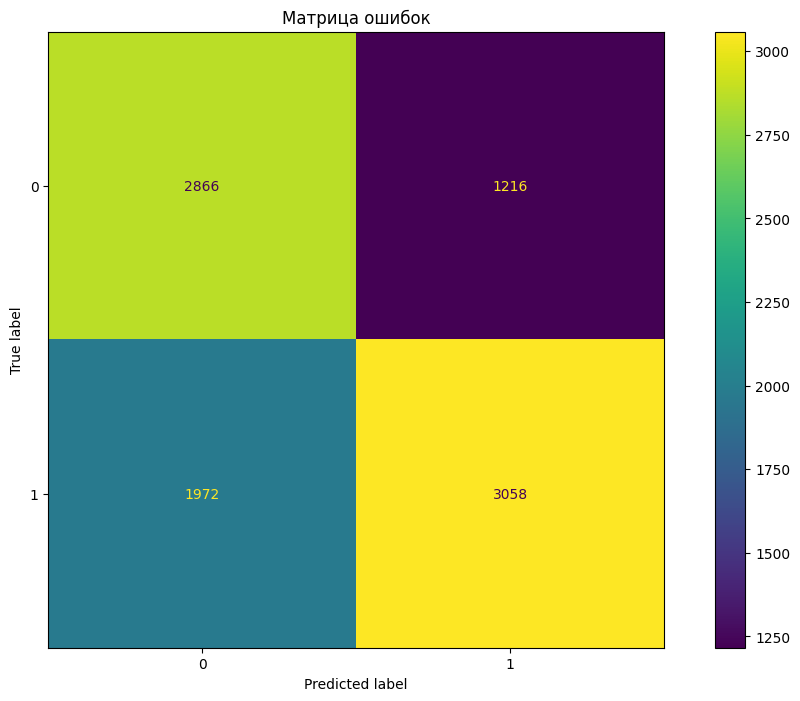

In [115]:
confusion_matrix_arr = confusion_matrix(y_test, prediction_gbm)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_arr,  display_labels = gs_gbm.classes_)
cm_display.plot()
plt.title('Матрица ошибок')
plt.show()

На данной матрице мы можем увидеть, в каком именно соотношении наша модель даёт правильные или неправильные предсказания.

По большей части модель справляется и даёт верные ответы - 2866 отрицательных предсказаний и 3058 положительных.
Но также модель и ошибается - она даёет 1216 неверных положительных ответов, которые на самом деле отрицательные, и 1972 неверных отрицательных ответов, которые на самом деле положительны.

Если перенести данные в процентное соотношение, то получится, что модель ошибается в 40,76% случаях при определении отрицательного класса и в 28,45% случаях при определении положительного.

В целом, работу модели можно считать успешной.

Выведем полноту и точность на график.

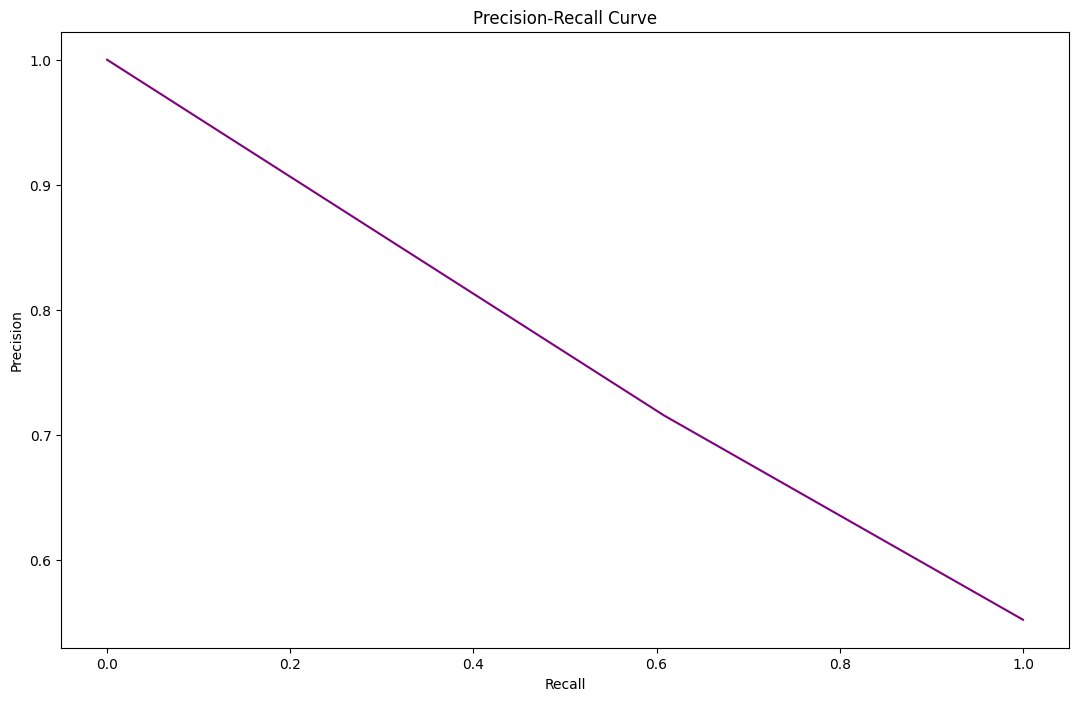

In [116]:
precision, recall, thresholds = precision_recall_curve(y_test, prediction_gbm)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

Можем также оценить важнейшие метрики для задачи классификации - полноту и точность - на представленном графике. Обычно достигается компромисс между точностью и полнотой. Например, можно увеличить точность за счет уменьшения полноты.

Кривая “точность-полнота” отражает этот компромисс при различных порогах классификации.

Далее приступим к анализу важнейших факторов для модели, которые могут сильнее остальных повлиять на виновность в ДТП. Построим столбчатую диаграмму.

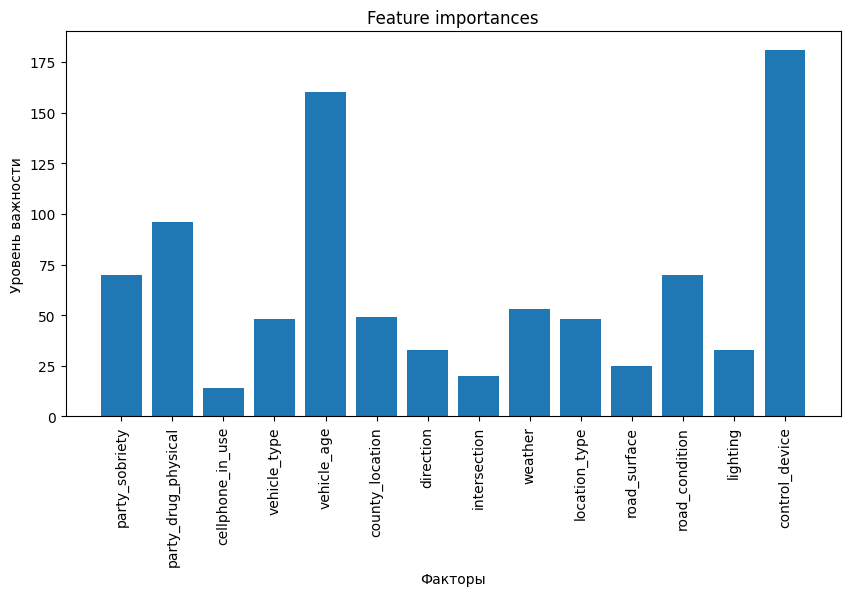

In [117]:
X_encoded = gs_gbm.best_estimator_['columntransformer'].fit_transform(X_train)
model = gs_gbm.best_estimator_['lgbmclassifier'].fit(X_encoded, y_train)

plt.figure(figsize=(10, 5))
plt.bar(X.columns, model.feature_importances_)
plt.xticks(rotation = 90)
plt.title('Feature importances')
plt.xlabel('Факторы')
plt.ylabel('Уровень важности')
plt.show()

In [118]:
sorted(list(zip(model.feature_importances_, X.columns)))

[(14, 'cellphone_in_use'),
 (20, 'intersection'),
 (25, 'road_surface'),
 (33, 'direction'),
 (33, 'lighting'),
 (48, 'location_type'),
 (48, 'vehicle_type'),
 (49, 'county_location'),
 (53, 'weather'),
 (70, 'party_sobriety'),
 (70, 'road_condition'),
 (96, 'party_drug_physical'),
 (160, 'vehicle_age'),
 (181, 'control_device')]

Важнейшими факторами оказались:

*   контролирующее устройство;
*   возраст автомобиля;
*   физическое или наркотическое состояние;
*   состояние дороги;
*   трезвость водителя.

Более подробно мы рассмотрим факторы наличия контролирующего устройтва и возраст автомобиля, так как на них есть возможность повлиять, остальные факторы не связаны с состоянием автомобиля.

### Наличие контролирующего устройства (ABS) в автомобиле

Построим столбчатую диаграмму и посмотрим визуально на зависимоть целевого значения от этого фактора. 

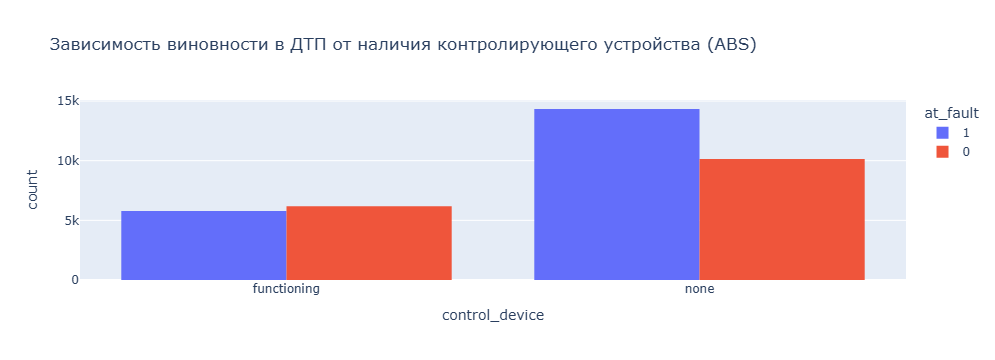

In [119]:
fig = px.histogram(
    data_impotant, x='control_device', color='at_fault',
    barmode='group',
    title='Зависимость виновности в ДТП от наличия контролирующего устройства (ABS)',
    histfunc='count'
)
fig.show()

Видим, что большая доля выборки иллюстрирует отсутствие ABS в машине, и виновников в этой категории больше. Если взять в процентном соотношении, то из всех водителей, у кого контролирующее устройство всё-таки оказывается в автомобиле, виновными в аварии становятся примерно 53,4%, а у тех, у кого этого устройства в машине не обнаружено - 45,07%. 

### Возраст автомобиля

Такой же диаграммой проиллюстрируем зависимость виновсти от возраста автомобиля.

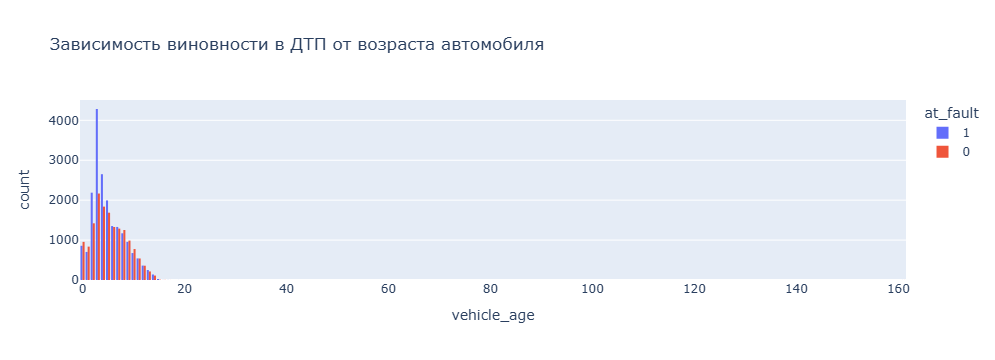

In [120]:
fig = px.histogram(
    data_impotant, x='vehicle_age', color='at_fault',
    barmode='group',
    title='Зависимость виновности в ДТП от возраста автомобиля',
    histfunc='count'
)
fig.show()

На графике можем заметить достаточно странную тенденцию, что на 2, 3 и 4 год эксплуатации автомобиля приходится больше водителей, виновных в ДТП. Возможно, это имеет связь с недостаточно внимательным и детальным облуживанием в эти годы, так как создаётся впечатление, что автомобили ещё новые. Но скорее всего модель ложно оценила важность этого признака и в этом случае лучше смотреть на стаж водителей, так как неопытные водители могут купить новый автомобиль и попасть в дтп.
Но к сожалению данного признака нет в датасете. Также было бы интересно проанализировать распределение по полу участников, так как женщины обычно водят аккуратней.

### Рекомендации для заказчика

Для заказчика можем выдвинуть следующие предложения:

1. Все автомобили необходимо оборудовать системой ABS;
2. Проводить техническое обслуживание новых автомобилей.

## Выводы

В данной работе мы постарались создать систему для каршеринговой компании, которая могла бы оценить риск ДТП по совокупности факторов.

1. Мы исследовали предоставленную базу, провели статистический анализ некоторых факторов и смогли сделать следующие выводы:

* **наибольшое** количество аварий происходит в ***октябре***, а **наименьшее** - в ***июне***. Такая зависимость может быть связана с ухудшением погодных условий и освещаемости в осенние месяцы, в течение которых и наблюдается активный рост аварий;

* во всех группах состояния дорожного покрытия мы можем заметить крайне схожые паттерны распределения повреждений. В ходе анализа также выяснилось, что большая часть происшествий приходится на сухие дороги, а наименьшая - на скользкие, грязные и маслянистые;

* в количественном отношении во всех категориях кроме легких повреждений лидируют машины с типом кузова ***купе***. В процентном соотношении внутри групп лидеры поменялись. В категории "Царапины" лидируют Купе. В категории "Средние повреждения" лидируют Минивены, а в категории "Не подлежит восстановлению", "Серьезные повреждения" - лидер Хачбек.

2. Мы подготовили набор данных на основе требований заказчика. Проанализировали все факторы на предмет того, насколько они влияют на вероятность ДТП.

  Обработали данные: убрали аномалии, почистили или заполнили пропуски, где это возможно, избавились дубликатов и поменяли типы данных на более рациональные. Также поделили выборку на тренировочную и тестовую.

3. Испытанные модели показали лучшие результаты по сравнению со случайной моделяю, что говорит о том что внедрение данных систем позволит улучшить вероятность опознать потенциального виновника ДТП по ряду признаков.

  Из представленных результатов увидели, что лучше всех с нашей задачей по всем трём метрикам (Precision, Recall и F1-мера) справилась модель `Light GBM`.

4. Мы увидели что самыми влияющими факторами являются:

*   контролирующее устройство;
*   возраст автомобиля;
*   физическое или наркотическое состояние;
*   трезвость водителя;
*   состояние дороги.

  Также расписали подробные рекомендации для заказчика, которые вероятно смогут повлиять на безопасноть водителей.

Возможно ли создать адекватную системы оценки водительского риска при выдаче авто? Да возможно, но нужно бальше информации об участниках происшествия и история поездок без ДТП.